In [1]:
import pandas as pd
import numpy as np
from random import choice
from glob import glob
import os
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, ttest_ind
from sklearn.metrics import r2_score

plt.style.use('ggplot')

In [2]:
input_root = "../../data/output/xgbooster/"
monitor_root = "../../data/csv/monitor"
test_root = "../../data/csv/aqi_csv_test/"
target_name = "API"

In [3]:
# load coordinates
monitor_coords = pd.read_csv(os.path.join(monitor_root, "monitor_processed.csv"))
monitor_coords = monitor_coords.drop(['city_cn', 'station_cn', 'lon', 'lat'], axis=1)
monitor_coords.set_index("id", inplace=True)

# CV

In [4]:
# load cv dataset
files = glob(os.path.join(input_root, target_name, "test/", "*.csv"))
cv = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)
cv['date'] = pd.to_datetime(cv['date'])
cv.set_index(['id'], inplace=True)

In [5]:
cv = cv.join(monitor_coords)

In [6]:
cv = cv.groupby(['city_id', 'city_en', 'date'])[['pred', 'true']].mean().reset_index()
cv.set_index('city_id', inplace=True)

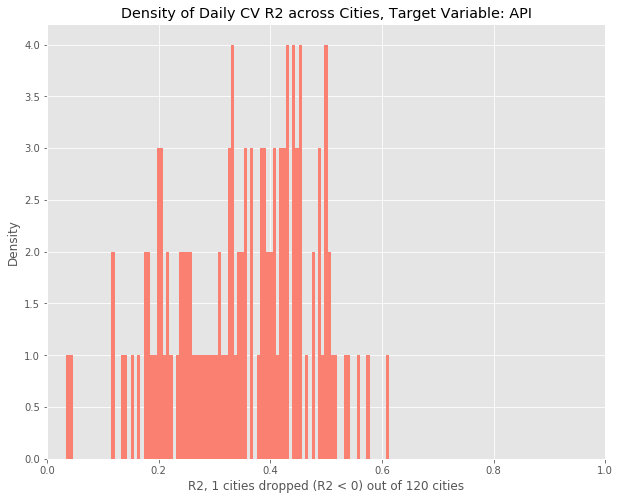

In [7]:
grouped = cv.groupby('city_id')
r2 = pd.DataFrame([[station_id, r2_score(group.true.values, group.pred.values)] for station_id, group in grouped],
                  columns=['id', 'r2'])
r2.to_csv(os.path.join(input_root, target_name, "city_r2_cv.csv"), index=False)

# analysis
plt.figure(figsize=(10, 8))
plt.xlim((0, 1))
plt.hist(r2.r2[r2.r2.between(0, 1)], bins=100, color="salmon")
plt.title("Density of Daily CV R2 across Cities, Target Variable: {}".format(target_name))
plt.xlabel("R2, {} cities dropped (R2 < 0) out of {} cities".format(sum(r2.r2.values < 0), r2.shape[0]))
plt.ylabel("Density")
plt.show()

## Examine Cities

In [8]:
city_ids = cv.index.get_level_values('city_id').unique().tolist()

In [9]:
# or specify city_id
# city_id = 8

In [10]:
city_id = choice(city_ids)

In [11]:
tmp = cv.loc[city_id, :]

print("t-test p-values: {:.6f}; ks-test p-values: {:.6f}".format(
    ttest_ind(tmp.pred, tmp.true, equal_var=False)[1],
    ks_2samp(tmp.pred, tmp.true)[1]))

t-test p-values: 0.564596; ks-test p-values: 0.000000


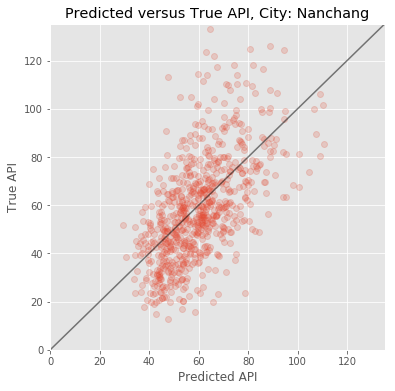

In [12]:
upper = np.maximum(np.percentile(tmp.pred, 99), np.percentile(tmp.true, 99))

plt.figure(figsize=(6, 6))
plt.plot(tmp.pred, tmp.true, 'o', alpha=0.2)
plt.xlim(0, upper)
plt.ylim(0, upper)
plt.plot([0, upper], [0, upper], 'k-', alpha=0.5)
plt.title("Predicted versus True API, City: {}".format(tmp.city_en.unique()[0]))
plt.xlabel("Predicted API")
plt.ylabel("True API")
plt.show()

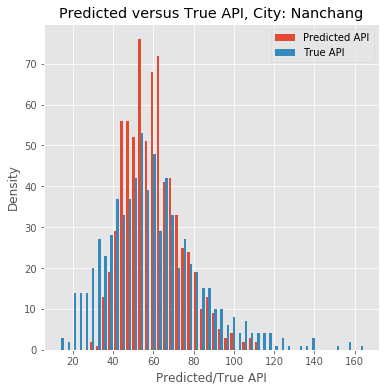

In [13]:
plt.figure(figsize=(6, 6))
plt.hist(tmp[['pred', 'true']].values, label=['Predicted API', 'True API'], bins=50)
plt.title("Predicted versus True API, City: {}".format(tmp.city_en.unique()[0]))
plt.xlabel("Predicted/True API")
plt.ylabel("Density")
plt.legend()
plt.show()

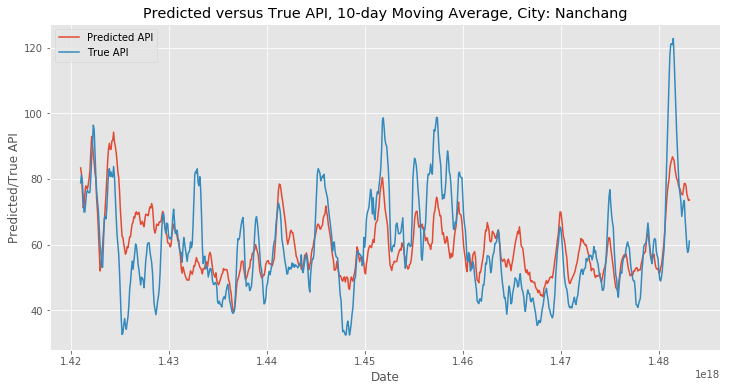

In [14]:
plot_window = 10

plt.figure(figsize=(12, 6))
plt.plot(tmp.date, tmp.pred.rolling(window=plot_window).mean(), label="Predicted API")
plt.plot(tmp.date, tmp.true.rolling(window=plot_window).mean(), label="True API")
plt.title("Predicted versus True API, {}-day Moving Average, City: {}".format(
    plot_window,
    tmp.city_en.unique()[0]))
plt.xlabel("Date")
plt.ylabel("Predicted/True API")
plt.legend()
plt.show()

# Test

In [15]:
files = glob(os.path.join(test_root, "*.csv"))
test = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)
test['date'] = pd.to_datetime(test['date'])
test.set_index(['id', 'date'], inplace=True)
test = test[["target_" + target_name]]
test.columns = pd.Index(["true"])

In [16]:
output = pd.read_csv(os.path.join(input_root, target_name, "prediction_output.csv"))
output['date'] = pd.to_datetime(output['date'])
output.set_index(['id', 'date'], inplace=True)

In [17]:
test = test.join(output).dropna()

In [18]:
test = test.join(monitor_coords)

In [19]:
test = test.groupby(['city_id', 'city_en', 'date'])[['pred', 'true']].mean().reset_index()
test.set_index('city_id', inplace=True)

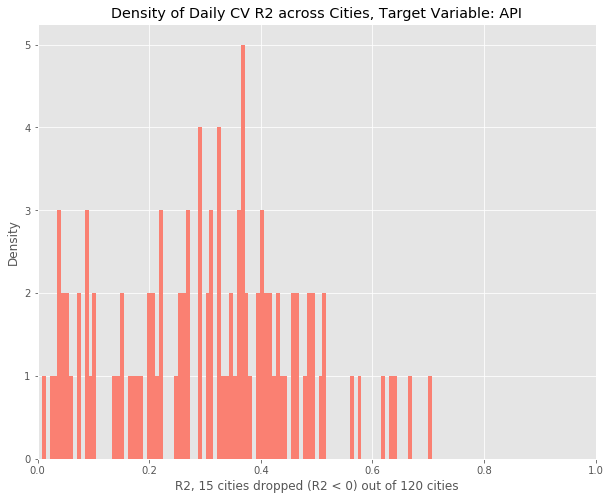

In [20]:
grouped = test.groupby('city_id')
r2 = pd.DataFrame([[station_id, r2_score(group.true.values, group.pred.values)] for station_id, group in grouped],
                  columns=['id', 'r2'])
r2.to_csv(os.path.join(input_root, target_name, "city_r2_test.csv"), index=False)

# analysis
plt.figure(figsize=(10, 8))
plt.xlim((0, 1))
plt.hist(r2.r2[r2.r2.between(0, 1)], bins=100, color="salmon")
plt.title("Density of Daily CV R2 across Cities, Target Variable: {}".format(target_name))
plt.xlabel("R2, {} cities dropped (R2 < 0) out of {} cities".format(sum(r2.r2.values < 0), r2.shape[0]))
plt.ylabel("Density")
plt.show()

## Examine Cities

In [21]:
city_ids = test.index.get_level_values('city_id').unique().tolist()

In [22]:
# or specify city_id
# city_id = 8

In [26]:
city_id = choice(city_ids)

In [27]:
tmp = test.loc[city_id, :]

print("t-test p-values: {:.6f}; ks-test p-values: {:.6f}".format(
    ttest_ind(tmp.pred, tmp.true, equal_var=False)[1],
    ks_2samp(tmp.pred, tmp.true)[1]))

t-test p-values: 0.000173; ks-test p-values: 0.000125


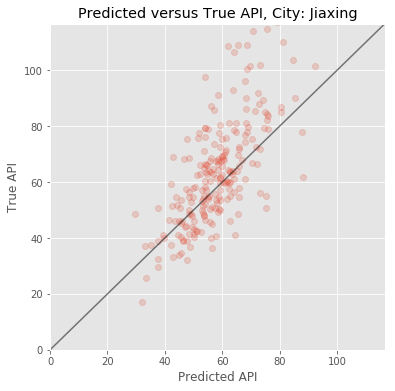

In [28]:
upper = np.maximum(np.percentile(tmp.pred, 99), np.percentile(tmp.true, 99))

plt.figure(figsize=(6, 6))
plt.plot(tmp.pred, tmp.true, 'o', alpha=0.2)
plt.xlim(0, upper)
plt.ylim(0, upper)
plt.plot([0, upper], [0, upper], 'k-', alpha=0.5)
plt.title("Predicted versus True API, City: {}".format(tmp.city_en.unique()[0]))
plt.xlabel("Predicted API")
plt.ylabel("True API")
plt.show()

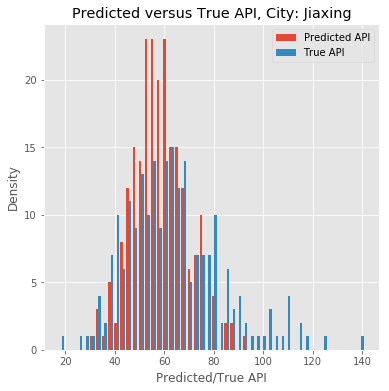

In [29]:
plt.figure(figsize=(6, 6))
plt.hist(tmp[['pred', 'true']].values, label=['Predicted API', 'True API'], bins=50)
plt.title("Predicted versus True API, City: {}".format(tmp.city_en.unique()[0]))
plt.xlabel("Predicted/True API")
plt.ylabel("Density")
plt.legend()
plt.show()

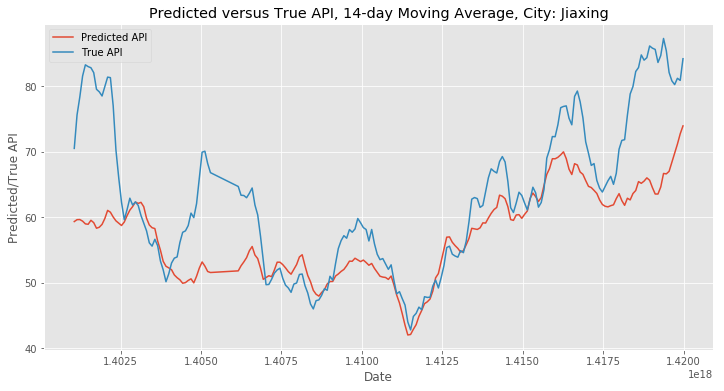

In [30]:
plot_window = 14

plt.figure(figsize=(12, 6))
plt.plot(tmp.date, tmp.pred.rolling(window=plot_window).mean(), label="Predicted API")
plt.plot(tmp.date, tmp.true.rolling(window=plot_window).mean(), label="True API")
plt.title("Predicted versus True API, {}-day Moving Average, City: {}".format(
    plot_window,
    tmp.city_en.unique()[0]))
plt.xlabel("Date")
plt.ylabel("Predicted/True API")
plt.legend()
plt.show()